In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
! pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import nltk
import textwrap
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt

In [3]:
# download the nltk tokenizer
nltk.download('punkt')

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda


## 1. Vocabulary and Tokenizer
Tokenize the given captions based on nltk.tokenize.word_tokenize()funtion 

Then convert to numericals

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold=1):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}

    def __len__(self):
        return len(self.itos)

    # this will generate the dictionary of words given list of sentences
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        # starting index for new words
        idx = 4
        for sentence in sentence_list:
            # tokenize the sentence using nltk
            tokens = nltk.tokenize.word_tokenize(sentence.lower())
            for token in tokens:
                # if the token is not in the dictionary already make it using 0+1 frequency
                frequencies[token] = frequencies.get(token, 0) + 1
                # if the token is new token that means it frquency is 1 add to the tok-idx and idx-tok
                if frequencies[token] == self.freq_threshold:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1

    # a sententence pass then it convert to numerical representation pass as string 
    def encode(self, text):
        tokenized_text = nltk.tokenize.word_tokenize(text.lower())
        return [self.stoi.get(token, self.stoi["<unk>"]) for token in tokenized_text]

    # convert back to words pass as normal python list
    def decode(self, tokens):
        return [self.itos.get(token, "<unk>") for token in tokens]
        

    # give the token and return the index of that token
    def __call__(self, token):
        return self.stoi.get(token, self.stoi["<unk>"])

In [5]:
# make the sentence list given caption file
all_captions = []
captions_file_path = '/kaggle/input/flickr8k/captions.txt'
images_dir = '/kaggle/input/flickr8k/Images'

with open(captions_file_path, 'r') as f:
    for i, line in enumerate(f):
        # skip the first line
        if i == 0:
            continue 
        line = line.strip()
        if line:
            # split on the first comma only
            _, caption = line.split(',', 1)
            all_captions.append(caption)

In [6]:
# debug cell
print(all_captions[:10])
# check whether the vocabulary is working well
vocab = Vocabulary()
vocab.build_vocabulary(all_captions)
print(len(vocab))

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .', 'A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
8922


In [7]:
print(vocab.decode([1,2,3]))

['<start>', '<end>', '<unk>']


## 2. Custom Dataset for Flickr8k
In the caption file there is image name and the caption.

So we have to define the way of getting an image and the caption from the dataset

In [8]:
# extend the dataset class from pytorch to get the data
class FlickrDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform=None, vocab=None):
        # captions_file: path to captions.txt file.
        # images_dir: directory with images.
        # transform: torchvision transforms for image pre-processing.
        # vocab: Vocabulary object.
        self.images_dir = images_dir
        self.transform = transform
        self.vocab = vocab
        # list of tuples: (image_filename, caption)
        self.image_captions = []

        # open the file and fill the image_captions list with
        with open(captions_file, 'r') as f:
            for i, line in enumerate(f):
                # skip the first line header
                if i == 0:
                    continue 
                line = line.strip()
                if line:
                    # split on the first comma only
                    image_name, caption = line.split(',', 1)
                    all_captions.append(caption)
                    # add to the image_captions list
                    self.image_captions.append((image_name, caption))

    # get the length of the dataset 
    def __len__(self):
        return len(self.image_captions)

    # define how to get an item from dataset
    def __getitem__(self, idx):
        # from given index get an image_caption dataset
        img_name, caption = self.image_captions[idx]
        # add to the image directory
        img_path = os.path.join(self.images_dir, img_name)
        # open the image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # numericalize caption with start and end tokens
        tokens = [self.vocab.stoi["<start>"]]
        tokens += self.vocab.encode(caption)
        tokens.append(self.vocab.stoi["<end>"])
        caption_tensor = torch.tensor(tokens)
        # return image and the caption tensor
        return image, caption_tensor

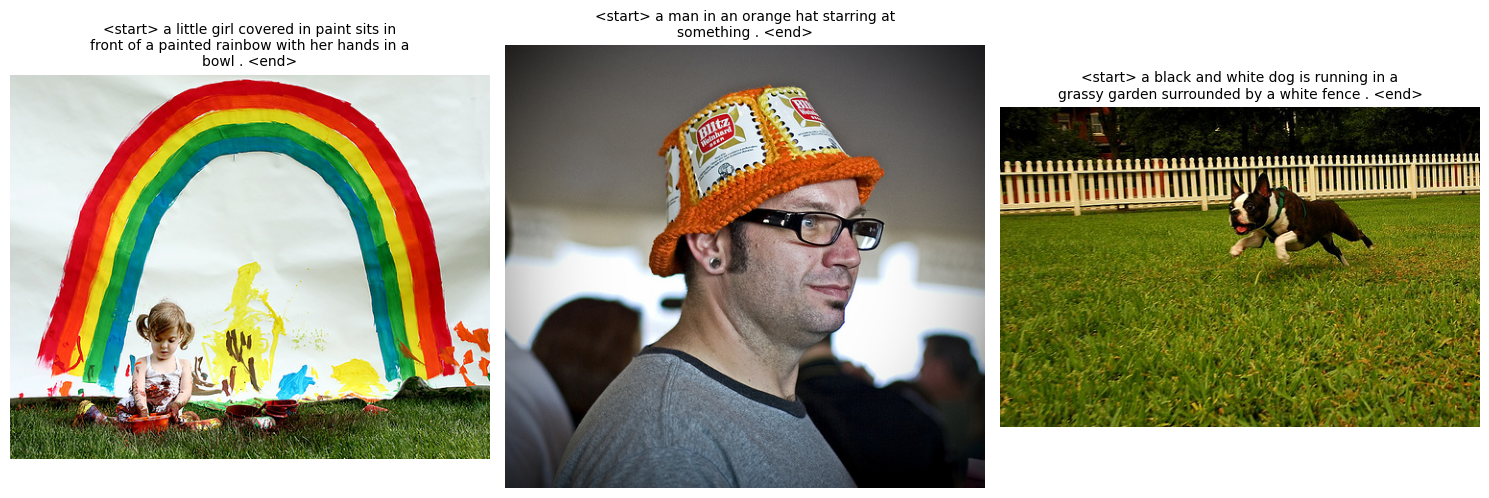

In [9]:
# debug cell
dataset = FlickrDataset(captions_file_path, images_dir, vocab=vocab)

# create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot the images with the correct captions 
for i,img_idx in enumerate([10,20,30]):
    # get image and caption
    image, caption = dataset[img_idx]
    # convert back to the words

    decode_caption = vocab.decode(caption.tolist())
    wrapped_caption = textwrap.fill(" ".join(decode_caption), width=50)
    
    # plot image
    axes[i].imshow(image)
    axes[i].axis("off") 
    axes[i].set_title(wrapped_caption, fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
# train test split
dataset_length = len(dataset)
train_size = int(0.8 * dataset_length)
val_size = dataset_length - train_size

# legth of the train val dataset
print("size of the train dataset:", train_size)
print("size of the val dataset:", val_size)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

size of the train dataset: 32364
size of the val dataset: 8091


## 3. Transform image to correct shape

First, Image are in different shape So they are resize and normalize images

In [11]:
# image transformations resize, center crop, convert to tensor and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# get image and caption
image, caption = dataset[img_idx]

if isinstance(image, torch.Tensor):
    image = F.to_pil_image(image)

# then transform to check output size of the image
transformed_image = transform(image)

# check output size
print("transformed image shape:", transformed_image.shape)

transformed image shape: torch.Size([3, 224, 224])


In [12]:
# get batch of data and adjust to the batch processing 
def collate_fn(batch, vocab):
    # batch is a list of (image, caption_tensor) tuples
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    # all images are stack together
    images = torch.stack(images, 0)
    # Pad captions
    lengths = [len(cap) for cap in captions]
    max_len = max(lengths)
    padded_captions = torch.zeros(len(captions), max_len).long()
    for i, cap in enumerate(captions):
        # get the caption of a batch and change it 
        end = lengths[i]
        # chage first half to the correct token
        padded_captions[i, :end] = cap[:end]
    return images, padded_captions

In [15]:
# make data loaders to test the encoder and decoder
dataset = FlickrDataset(captions_file_path, images_dir, transform=transform, vocab=vocab) 
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda batch: collate_fn(batch, vocab))  

# test the dataloader enumerate through the dataset
for i, (images, captions) in enumerate(dataloader):
    print("transformed image shape:", images.shape)
    print("caption size(can be changed):", captions.shape)

    # sample batch data save to the sample_batch
    sample_batch_images, sample_batch_captions = images.to(device), captions.to(device)
    
    # break the 
    if i == 4:
        break

transformed image shape: torch.Size([64, 3, 224, 224])
caption size(can be changed): torch.Size([64, 30])
transformed image shape: torch.Size([64, 3, 224, 224])
caption size(can be changed): torch.Size([64, 22])
transformed image shape: torch.Size([64, 3, 224, 224])
caption size(can be changed): torch.Size([64, 31])
transformed image shape: torch.Size([64, 3, 224, 224])
caption size(can be changed): torch.Size([64, 27])
transformed image shape: torch.Size([64, 3, 224, 224])
caption size(can be changed): torch.Size([64, 32])


## 4.Make Restnet-101 Encoder layer
images are encoded into the resnet architecture so it goes through the resnet101 model

In [ ]:
# %% [Cell 6] - Build Custom VGG16 Encoder (from scratch)
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # With input size 244x244, the feature map should be roughly 7x7 after pooling.
        self.fc = nn.Linear(512 * 7 * 7, embed_size)
    
    def forward(self, x):
        # forward through the convolution layers
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        # pass through the lenear layer to make size as embedded dim
        x = self.fc(x)
        # output (batch_size, embed_size)
        return x

In [16]:
## with the pre-trained model
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        # Load the pretrained ResNet-101 model
        resnet = models.resnet101(pretrained=True)
        # Remove the last fully connected layer
        modules = list(resnet.children())[:-1]  # remove the original FC layer
        self.resnet = nn.Sequential(*modules)
        # New fully connected layer to map from resnet's output features to embed_size
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        # Optionally add a batch normalization layer
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        # Pass the images through ResNet-101 up to the last pooling layer.
        features = self.resnet(images)  # shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # shape: (batch_size, 2048)
        features = self.fc(features)                  # shape: (batch_size, embed_size)
        features = self.bn(features)                  # shape: (batch_size, embed_size)
        return features

In [ ]:
# After the convolution layer it should map to the embedding size
embed_size=256
# Debug: Instantiate encoder and verify output shape for a batch of images.
encoder = Encoder(embed_size).to(device)
sample_batch = next(iter(dataloader))[0].to(device)  # Batch of images from DataLoader.
features = encoder(sample_batch_images)
print("Encoder output shape (expected [batch_size, embed_size]):", features.shape)

## 5. Make decoder layer using LSTM

What happen in the decoder is simply done by below cell

In [ ]:
# get the encoding of the batch
features = encoder(sample_batch_images)

# parameters of lstm
vocab_size = 8922
hidden_size = 512
embed_size = 256
num_layers = 1
batch_size = 32 

# initialize the lstm and embedding
lstm_cell  = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True).to(device)
embed = nn.Embedding(vocab_size, embed_size).to(device)

max_length = sample_batch_captions.shape[-1]
# Initialize LSTM hidden state to None so it is internally zeroed.
h0 = torch.zeros(1, 1, hidden_size).to(device) # (seq_len, batch_size, hidden_size)
c0 = torch.zeros(1, 1, hidden_size).to(device) # (seq_len, batch_size, hidden_size)

# add seq_len = 1 to the feature of the image
features = features.unsqueeze(0)

# first input the featues to the lstm
lstm_out, (h_n,c_n) = lstm_cell(features, (h0, c0))

# for the first time step we can pass like above 
print(lstm_out.shape,h_n.shape)

# extend to the one batch of 
# for teacher forcing method we should shift right and add first time step as the encoding of the image
embed_captions = embed(sample_batch_captions)
print("(batch_size, seq_len, embed_size) : ", embed_captions.shape) # (batch_size, seq_len, embed_size)

# before pass to the lstm we should make as (seq_len, batch_size, embed_size)
embed_captions = embed_captions.permute(1, 0, 2)

# then add the initial state to the sequence by right shifting by one and add featues to 0 th position 
embed_captions_shifted = embed_captions[:-1, :, :]

# concatenate from the seq_len position
inputs = torch.cat((features, embed_captions_shifted), dim=0)

# then pass to the lstm
# Defaults to zeros if (h_0, c_0) is not provided.
lstm_out, (h_n,c_n) = lstm_cell(inputs)

print("lstm output size is (seq_len, batch_size, hidden_size(as ouput size))", lstm_out.shape)

### input, (h_0, c_0) = input of the lstm 

input -> (L[time_step], N[batch_size], H[hidden_output_size])


### output, (h_n, c_n) = output of the lstm 

output(each time step output of the lstm) -> (L[time_step], N[batch_size], H[hidden_output_size])

h_n(last hidden state of the lstm last time step) -> (D[directions]*num_layers, N[batch_size], H[hidden_output_size])

In [17]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size

    def forward(self, features, captions):
        # features: encoded image features, shape (batch, embed_size)
        # captions: tokenized captions, shape (batch, caption_length)
        
        # add seq_len = 1 to the feature of the image
        features = features.unsqueeze(1)
        
        # for teacher forcing method we should shift right and add first time step as the encoding of the image
        embed_captions = self.embed(captions)

        # then add the initial state to the sequence by right shifting by one and add featues to 0 th position 
        embed_captions_shifted = embed_captions[:, :-1, :]

        # concatenate from the seq_len position
        inputs = torch.cat((features, embed_captions_shifted), dim=1)

        # then pass to the lstm
        # Defaults to zeros if (h_0, c_0) is not provided.
        lstm_out, _ = self.lstm(inputs)

        # then pass to the lenear layer to make it as vocabulary size
        outputs = self.linear(lstm_out)

        return outputs # (batch_size, seq_len, vocabulary_size)

    def generate(self, features, max_length=40):
        # normally batch_size == 1 for generation
        batch_size = features.size(0)
        
        hidden = (torch.zeros(self.lstm.num_layers, batch_size, self.hidden_size, device=features.device),
        torch.zeros(self.lstm.num_layers, batch_size, self.hidden_size, device=features.device))
        
        # The initial input is the image feature
        # Our LSTM is defined with batch_first=True, so we create a time dimension.
        inputs = features.unsqueeze(1)  # shape: (batch, 1, embed_size)
        
        generated_tokens = []
        
        for t in range(max_length):
            # Pass the current input through the LSTM.
            lstm_out, hidden = self.lstm(inputs, hidden)  # lstm_out: (batch, 1, hidden_size)
            
            # project LSTM output to vocabulary logits
            outputs = self.linear(lstm_out.squeeze(1))  # shape: (batch, vocab_size)
            
            # compute probabilities using softmax.
            probs = torch.softmax(outputs, dim=1)  # shape: (batch, vocab_size)
            
            # greedily select the word with the highest probability
            predicted = probs.argmax(dim=1)  # shape: (batch,)
            token_id = predicted.item()
            generated_tokens.append(token_id)
            
            # if the predicted token is the <end> token (assumed id = 2), stop generation
            if token_id == 2:
                break
            
            # prepare the next input by converting the predicted token into its embedding.
            inputs = self.embed(predicted).unsqueeze(1)  # shape: (batch, 1, embed_size)
        
        return generated_tokens

In [ ]:
# debug the decoder generator

# get the encoding of the batch
features = encoder(sample_batch_images)
print(features.shape)
features = features[0, :]
features = features.unsqueeze(0)
print(features.shape)

# initialize the decoder
decoder = Decoder(embed_size, hidden_size, vocab_size).to(device)

# generate sample tokens
generated_tokens = decoder.generate(features)

print(generated_tokens)

In [18]:
# hyperparameters and settings
embed_size   = 256
hidden_size  = 512
vocab_size   = 8922
num_layers   = 1
learning_rate = 0.001
num_epochs   = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# instantiate the Encoder and Decoder
encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers).to(device)

features = encoder(sample_batch_images)  # shape: (batch_size, embed_size)
outputs = decoder(features, sample_batch_captions) # shape: (batch_size, seq_length, vocab_size)
print(outputs.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 192MB/s] 


torch.Size([64, 32, 8922])


In [19]:
loss_values = []

# make the parameters loss calculation false
for param in encoder.parameters():
    param.requires_grad = False

# define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
params = list(decoder.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

# images: (batch_size, channels, height, width)
# captions: (batch_size, caption_length)
for epoch in range(num_epochs):
    for batch_idx, (images, captions) in enumerate(dataloader):
        images = images.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        
        # forward pass through Encoder and Decoder
        features = encoder(images)  # shape: (batch_size, embed_size)
        outputs = decoder(features, captions) 
        
        
        # reshape outputs and targets for the loss
        # outputs: (batch_size*caption_length, vocab_size)
        # targets: (batch_size*caption_length)
        loss = criterion(outputs.reshape(-1, vocab_size), captions.reshape(-1))

        # add the loss values to a list
        loss_values.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}")

Epoch [1/5], Batch [0], Loss: 9.1047
Epoch [1/5], Batch [100], Loss: 3.7740
Epoch [1/5], Batch [200], Loss: 3.3824
Epoch [1/5], Batch [300], Loss: 3.1592
Epoch [1/5], Batch [400], Loss: 3.0620
Epoch [1/5], Batch [500], Loss: 2.9230
Epoch [2/5], Batch [0], Loss: 2.9745
Epoch [2/5], Batch [100], Loss: 2.7090
Epoch [2/5], Batch [200], Loss: 2.9333
Epoch [2/5], Batch [300], Loss: 2.6519
Epoch [2/5], Batch [400], Loss: 2.7084
Epoch [2/5], Batch [500], Loss: 2.7731
Epoch [3/5], Batch [0], Loss: 2.3824
Epoch [3/5], Batch [100], Loss: 2.2816
Epoch [3/5], Batch [200], Loss: 2.4442
Epoch [3/5], Batch [300], Loss: 2.4816
Epoch [3/5], Batch [400], Loss: 2.3181
Epoch [3/5], Batch [500], Loss: 2.3655
Epoch [4/5], Batch [0], Loss: 2.2077
Epoch [4/5], Batch [100], Loss: 2.2724
Epoch [4/5], Batch [200], Loss: 2.3055
Epoch [4/5], Batch [300], Loss: 2.2728
Epoch [4/5], Batch [400], Loss: 2.0455
Epoch [4/5], Batch [500], Loss: 2.1111
Epoch [5/5], Batch [0], Loss: 2.1604
Epoch [5/5], Batch [100], Loss: 2.1

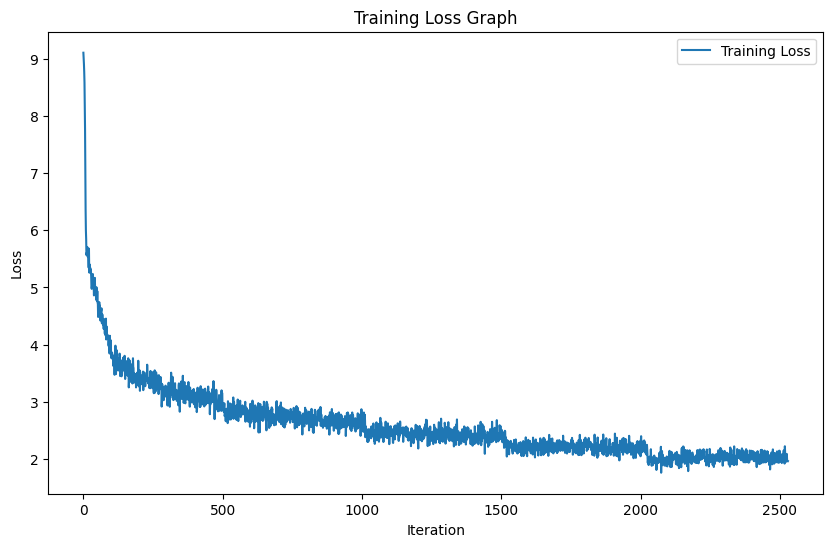

In [21]:
# Plot the loss graph after training
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Graph')
plt.legend()
plt.show()

In [22]:
encoder.eval()
decoder.eval()  

# disable the gradient calculation 
with torch.no_grad():
    i = 0
    for batch_idx, (images, captions) in enumerate(val_dataloader):
        images = images.to(device)
        captions = captions.to(device)
        
        # Forward pass
        features = encoder(images)  # shape: (batch_size, embed_size)
        outputs = decoder.generate(features) 
        
        # Convert to words
        predicted_captions = vocab.decode(outputs)
        correct_captions = vocab.decode(captions.squeeze(0).tolist())

        print("Correct: ", " ".join(correct_captions))
        print("Predicted: ", " ".join(predicted_captions))
        print("--------------------------------------------")

        if i == 10:
            break
        i += 1

NameError: name 'val_dataloader' is not defined

In [20]:
# after training is complete save the current state
checkpoint = {
    'epoch': epoch,
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(), 
}

torch.save(checkpoint, 'checkpoint.pth')
print("Checkpoint saved!")

Checkpoint saved!


In [ ]:
# Load the checkpoint
checkpoint = torch.load('checkpoint.pth', map_location=device)

# Restore the model states and optimizer state
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, retrieve other information
start_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

print(f"Checkpoint loaded! Resuming from epoch {start_epoch} with loss {last_loss}")